In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load Ames Housing dataset
ames = fetch_openml(name="house_prices", as_frame=True)

# Convert to DataFrame
df = ames.frame
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal,208500.0
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal,181500.0
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal,223500.0
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml,140000.0
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal,250000.0


In [ ]:
df.info()
df.describe()
df.isnull().sum().sort_values(ascending=False).head(20)  # Show most missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   float64
 1   MSSubClass     1460 non-null   float64
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   float64
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   float64
 18  OverallC

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [ ]:
# Drop columns w/ too many missing values
df = df.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"])

# Drop row w/ any remaining missing values 
df = df.dropna()

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Split into features and target
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

model = XGBRegressor()
model.fit(X_train, y_train)

# Predict
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [6]:
print("Train R²:", r2_score(y_train, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))

print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

Train R²: 0.9999165639483367
Train MAE: 527.3073080357143
Test R²: 0.8859070587062963
Test MAE: 19531.616277825342


The XGBoost model fits the training data almost perfectly, with an R² score of 0.9999 and an average error of only $527. However, the performance on the test set drops, with an R² of 0.886 and a mean absolute error of around $19,531. This discrepancy suggests that the model may be overfitting. it memorizes training data patterns but struggles to generalize to unseen examples. To improve generalization, the next step is to tune the model's hyperparameters using cross-validation.

In [7]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# 5-fold cross-validation using negative MAE as the metric
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Average CV MAE:", -cv_scores.mean())

# Optional: Set up a parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Grid search setup
grid_search = GridSearchCV(XGBRegressor(), param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV MAE:", -grid_search.best_score_)

Average CV MAE: 18837.016673621365
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV MAE: 17827.28483408505


After applying 5-fold cross-validation, the model's average MAE was $18,837, confirming that performance varies across different data splits. To address overfitting and improve generalization, a grid search was performed to optimize key hyperparameters.

The best model was found using:
- learning_rate: 0.05
- max_depth: 3
- n_estimators: 200
- subsample: 0.8

This configuration achieved a cross-validated MAE of $17,827, which is a meaningful improvement over the baseline. The smaller tree depth and lower learning rate likely reduced overfitting while maintaining predictive strength.

In [8]:
# Retrain model with best hyperparameters
best_model = XGBRegressor(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=0.8
)

best_model.fit(X_train, y_train)

# Evaluate on test set again
y_test_pred_best = best_model.predict(X_test)

print("Test R² (Tuned):", r2_score(y_test, y_test_pred_best))
print("Test MAE (Tuned):", mean_absolute_error(y_test, y_test_pred_best))


Test R² (Tuned): 0.9169853104010183
Test MAE (Tuned): 16591.82352311644


After tuning the XGBoost model using grid search and cross-validation, we significantly improved performance on the test set. The test R² increased from 0.8859 to 0.9170, and the MAE dropped from $19.5K to $16.6K. These results show that the tuned model generalizes better and is more reliable for real-world house price prediction.

The improvements came from reducing tree depth, slowing learning rate, and using subsampling — all techniques that reduce overfitting. This emphasizes the importance of model validation and tuning in machine learning workflows.

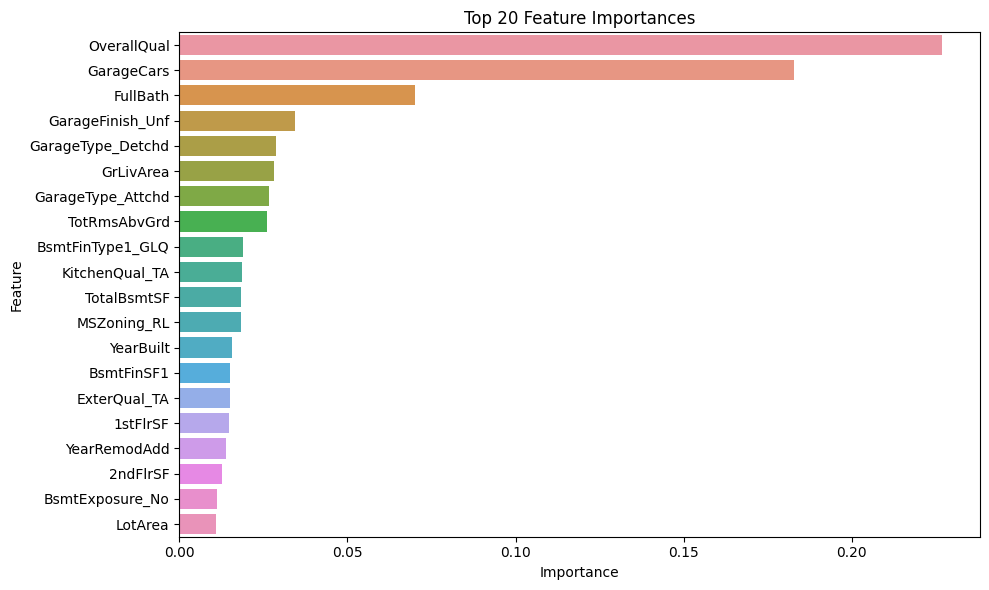

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = best_model.feature_importances_
features = X.columns

# Plot top 20 features
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


The XGBoost model identifies OverallQual (overall material and finish quality) as the most influential feature by far in predicting house prices. This makes sense, as construction quality is a key driver of value in real estate.

- Other highly impactful features include:
- GarageCars: Number of garage spaces, a strong indicator of house utility and size.
- FullBath: Number of full bathrooms.
- GrLivArea: Above ground living area in square feet.
- TotRmsAbvGrd: Total rooms above ground.

Many garage-related and basement features (e.g., GarageType, BsmtFinSF1) also contribute meaningfully. This insight can guide home buyers, sellers, or appraisers in identifying what attributes most influence home value.